# Imports

Working in the stim39 environemnt

In [11]:
#Imports
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from conversions import get_file_without_path
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR

import sklearn.feature_selection
from sklearn.feature_selection import mutual_info_regression

import statsmodels.api as sm
from scipy import signal
from scipy import stats

from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import random
from pyinform import mutual_info

from eelbrain import *


In [12]:
au_df = pd.read_csv("data/au_df_30hz.csv")

In [13]:
def get_file_tag_behavior(row):
    file_tag = get_file_without_path(row["participant_video"])
    return file_tag

#Merge with behavior data set
behavior_df = pd.read_csv("data/behavior_df.csv")
behavior_df["file_tag"] = behavior_df.apply(get_file_tag_behavior, axis=1)

behavior_df["question"] = behavior_df["question"] + ["_" for i in range(len(behavior_df))] + behavior_df["question_content"]

behavior_df = behavior_df.pivot_table(
        values='measure', 
        index=['file_tag', 'participant_nb', 'interacting_partner',"dyad", 'N', 'day','female_condition'
                       , 'female_video', 'individual_date', 'male_condition'
                       , 'male_video', 'sex', 'other_sex', 'participant_condition'
                       , 'other_condition', 'participant_video', 'other_video', "congruence"], 
        columns='question',
        aggfunc=np.mean)

behavior_df = behavior_df.reset_index()

# Compute mutual information and cross correlation for each dyad

In [14]:
source_features = ["happiness"]
target_features =  ["happiness"]
other_manipulations = [True,  False]

In [ ]:
#Both manipulated with the same value
lag = 300 # 10 seconds before and 10 seconds after

mi_df = pd.DataFrame()
df_lags = pd.DataFrame()
for other_manipulated in other_manipulations:
    for (participant_manipulated, dyad, participant_nb), dyad_df in au_df.groupby(["manipulated", "dyad", "participant_nb"]):
        
        if participant_manipulated == True:
            continue
            
        #Prepare participants' time series
        participant_df = dyad_df.loc[dyad_df["participant_nb"] == participant_nb]
        participant_df = participant_df.ffill(axis="rows")
        participant_df = participant_df.bfill(axis="rows")

        interacting_partner = np.unique(participant_df["interacting_partner"])[0]    
        partner_df = au_df.loc[au_df["participant_nb"] == interacting_partner]
        partner_df = partner_df.loc[partner_df["dyad"] == dyad]    
        partner_df = partner_df.loc[partner_df["manipulated"] == other_manipulated]        
        partner_df = partner_df.ffill(axis="rows")
        partner_df = partner_df.bfill(axis="rows")


        for source_feature in source_features:
            for target_feature in target_features:    

                #preapre participant time series
                X = participant_df[source_feature].values

                #preapre target time series
                y = partner_df[target_feature].values
                
                if dyad == "2_M3_PM2_F3_PM":
                    print("Artefact rejected")
                    continue
                    
                if "1_M4_AM1_F2_AM" == dyad:
                    print("Artefact rejected")
                    continue
                
                if ("2_M2_AM2_F4_AM" == dyad):
                    print("Artefact rejected")
                    continue

                #cross-correlation
                corr_X = [(val-np.nanmean(X))/np.nanstd(X) for val in X]
                corr_y = [(val-np.nanmean(y))/np.nanstd(y) for val in y]
                corr = signal.correlate(corr_X, corr_y, mode='same') 
                corr = corr  / len(X)

                #Select only cross correaltion between +/- 5s
                selected_corr = corr[round(len(corr)/2 - lag): round(len(corr)/2 + lag)]
                pears_r, p = stats.pearsonr(corr_X, corr_y)

                mean_corr = np.arctanh(np.nanmean(selected_corr))
                max_corr = np.arctanh(np.nanmax(selected_corr))
                min_corr = np.arctanh(np.nanmin(selected_corr))
                abs_mean_corr = np.arctanh(np.nanmean(abs(selected_corr)))
                std_corr = np.nanstd(selected_corr) 
                pears_r = np.arctanh(pears_r)

                #mi
                X = X.reshape(-1,1)    
                mi = mutual_info_regression(X=X, y=y
                                   , discrete_features = 'auto'
                                   , n_neighbors = 60
                                   , copy = True
                                   , random_state=None
                               )

                #Recover MI results
                aux_df = pd.DataFrame()
                aux_df["source_feature"]         = [source_feature]
                aux_df["target_feature"]         = [target_feature]
                aux_df["participant_manipulated"]  = [participant_manipulated]
                aux_df["interacting_partner"]  = [interacting_partner]
                aux_df["participant_nb"]  = [participant_nb]
                aux_df["other_manipulated"]  = [other_manipulated]            
                aux_df["dyad"]  = [dyad]
                aux_df["mi"]    = mi
                aux_df["mean_corr"] = [mean_corr]
                aux_df["max_corr"]  = [max_corr]

                aux_lags_df = pd.DataFrame()
                aux_lags_df["lag"]  = range(2*lag)
                aux_lags_df["lag"]  = aux_lags_df["lag"]-lag
                aux_lags_df["corr"] = selected_corr
                aux_lags_df["dyad"] = [dyad for i in range(len(aux_lags_df))]    
                aux_lags_df["source_feature"]         = [source_feature for i in range(len(aux_lags_df))]
                aux_lags_df["target_feature"]         = [target_feature for i in range(len(aux_lags_df))]
                aux_lags_df["participant_manipulated"]  = [participant_manipulated for i in range(len(aux_lags_df))]
                aux_lags_df["interacting_partner"]    = [interacting_partner for i in range(len(aux_lags_df))]
                aux_lags_df["participant_nb"]         = [participant_nb for i in range(len(aux_lags_df))]
                aux_lags_df["other_manipulated"]  = [other_manipulated for i in range(len(aux_lags_df))]            
                df_lags = pd.concat([df_lags, aux_lags_df])

                mi_df = pd.concat([mi_df, aux_df])

Artefact rejected
Artefact rejected


In [16]:
#Merge MI and cross corr results with behavior
mi_df = behavior_df.merge(mi_df, on=["dyad", "participant_nb", "interacting_partner"])

#compute normalisation measures
mi_df["norm_seeing_again"]          = mi_df["Q2_seeing_again"]          - mi_df["Q1_seeing_again"]
mi_df["norm_good_conversation"]     = mi_df["Q2_good_conversation"]     - mi_df["Q1_good_conversation"]
mi_df["norm_other_seeing_me_again"] = mi_df["Q2_other_seeing_me_again"] - mi_df["Q1_other_seeing_me_again"]
mi_df["norm_smile"]                 = mi_df["Q2_smile"] - mi_df["Q1_smile"]

#print len
print(len(mi_df))

228


In [21]:
#Merge lags with behavior
df_lags = behavior_df.merge(df_lags, on=["dyad", "participant_nb", "interacting_partner"])
df_lags.to_csv("data/lags_df_py_feat_"+source_feature+"_all_manipulated_pairs.csv")

In [23]:
def get_female_id(row):
    p = row["participant_nb"]
    i = row["interacting_partner"]
    sex = row["sex"]    
    
    if sex == "F":
        return p
    else:
        return i

def get_male_id(row):
    p = row["participant_nb"]
    i = row["interacting_partner"]
    sex = row["sex"]    
    
    if sex == "M":
        return p
    else:
        return i
    
df_analysis = mi_df.groupby(["dyad", "participant_nb", "interacting_partner"
                             , "sex", "male_condition", "female_condition"
                             , "participant_manipulated", "other_manipulated"
                             , "participant_condition", "other_condition"]).mean(numeric_only=True).reset_index()

df_analysis["male_id"]   = df_analysis.apply(get_male_id, axis=1)
df_analysis["female_id"] = df_analysis.apply(get_female_id, axis=1)

df_analysis.to_csv("data/mi_df_py_feat_"+source_feature+"_all_manipulated_pairs.csv")


# Plot time series

In [24]:
mi_df = pd.read_csv("data/mi_df_py_feat_happiness_all_manipulated_pairs.csv")

mi_df = mi_df.loc[mi_df["participant_manipulated"] == False]

In [26]:
au_df = pd.read_csv("data/au_df_30hz.csv")

In [35]:
zygo_vals = ["happiness"]
plot_folder = "plots/"

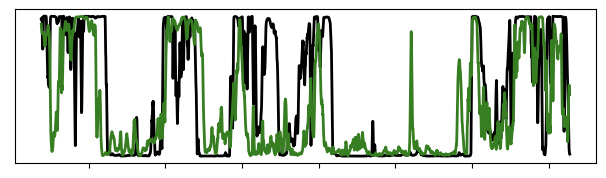

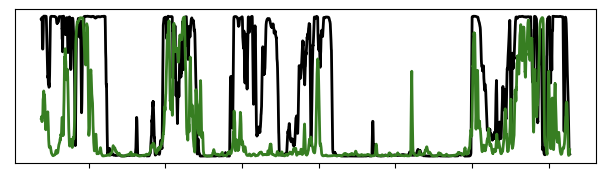

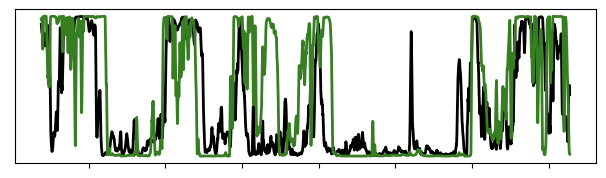

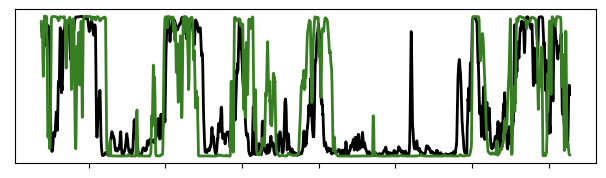

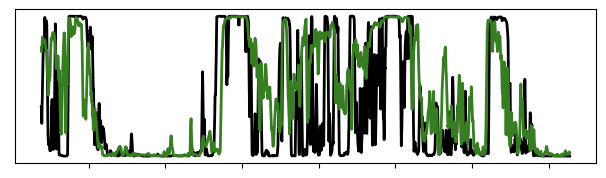

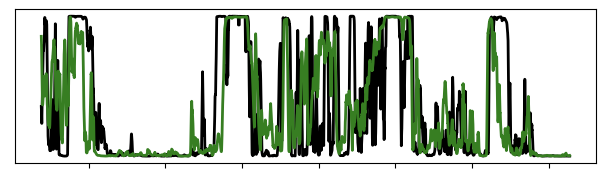

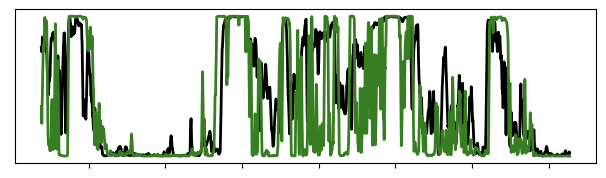

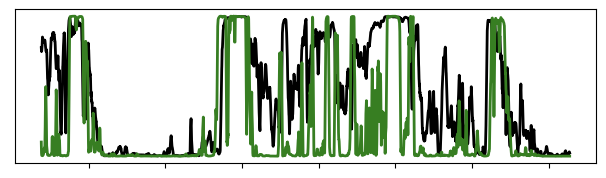

In [36]:
#Plots for paper

dayds = ["2_M4_PM2_F1_PM", "2_M2_AM2_F3_AM"]

start = 1000
stop = 6000

lw = 2


colors = ["#000000", "#377E22"]

for (dyad, participant_nb, interacting_partner, manipulated, other_manipulated), df in mi_df.groupby(["dyad", "participant_nb", "interacting_partner", "participant_manipulated", "other_manipulated"]):
    if dyad not in dayds:
        continue
        
    participant_df = au_df.loc[au_df["dyad"] == dyad]
    participant_df = participant_df.loc[participant_df["manipulated"] == manipulated] 
    participant_df = participant_df.loc[participant_df["participant_nb"] == participant_nb]
    participant_df = participant_df.ffill(axis="rows")
    participant_df = participant_df.bfill(axis="rows")
    
    partner_df = au_df.loc[au_df["dyad"] == dyad]
    partner_df = partner_df.loc[partner_df["manipulated"] == other_manipulated] 
    partner_df = partner_df.loc[partner_df["participant_nb"] == interacting_partner]
    partner_df = partner_df.ffill(axis="rows")
    partner_df = partner_df.bfill(axis="rows")
    
    if len(np.unique(df["max_corr"])) > 1 :
        print("error more than one mi measure")

    max_corr = np.unique(df["max_corr"])[0]
    max_corr = int(max_corr*1000)
    
    mi = np.unique(df["mi"])[0]
    mi = int(mi*1000)

    #plot
    plt.figure(figsize=(7.5, 2))
    plt.plot((participant_df["frame"].values/29)[start:stop], participant_df[zygo_vals].values[start:stop], lw=lw, color=colors[0])
    plt.plot((partner_df["frame"].values/29)[start:stop], partner_df[zygo_vals].values[start:stop], lw=lw, color=colors[1])

    #plt.ylim([-0.1, 1.07])
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])    
    plt.yticks([])
    
    plt.savefig(plot_folder + "_max_corr_"+ format(max_corr, '04d') + "_"  + dyad+"_"+ participant_nb + "_" + str(manipulated) + "_" + interacting_partner + "_" + str(other_manipulated) + ".pdf", bbox_inches='tight')
    plt.savefig(plot_folder + "_mi_"+ format(mi, '04d') + "_"  + dyad+"_"+ participant_nb + "_" + str(manipulated) + "_" + interacting_partner + "_" + str(other_manipulated) + ".pdf", bbox_inches='tight')
    

# Mututal Information

In [38]:
mi_df = pd.read_csv("data/mi_df_py_feat_happiness_all_manipulated_pairs.csv")

mi_df = mi_df.loc[mi_df["participant_manipulated"] == False]

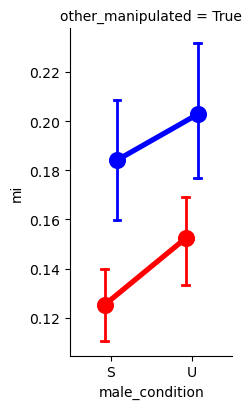

In [39]:
df_analysis = mi_df.reset_index()

df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]
df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == True]

df_analysis = df_analysis.groupby(["participant_nb", "male_condition", "female_condition", "other_manipulated"]).mean(numeric_only=True).reset_index()

g = sns.catplot(x="male_condition", y="mi", hue="female_condition"
            , units="participant_nb"
            , col="other_manipulated"
            , palette = ["#FF0000", "#0000FF"]
            , data=df_analysis, kind="point", sharey=False
            , aspect=0.6
            , capsize=.08
            , scale=1.4
            , dodge= 0.15
            , errwidth=2      
            , height=4.2     
            , legend=False
           )

#g.set(ylim=(-0.8, 0.9))

#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)

plt.savefig("plots/mi.pdf", bbox_inches='tight')


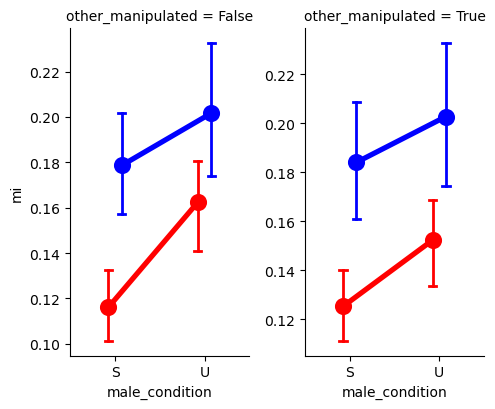

In [40]:
df_analysis = mi_df.reset_index()

df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]

df_analysis = df_analysis.groupby(["participant_nb", "male_condition", "female_condition", "other_manipulated"]).mean(numeric_only=True).reset_index()

g = sns.catplot(x="male_condition", y="mi", hue="female_condition"
            , units="participant_nb"
            , col="other_manipulated"
            , palette = ["#FF0000", "#0000FF"]
            , data=df_analysis, kind="point", sharey=False
            , aspect=0.6
            , capsize=.08
            , scale=1.4
            , dodge= 0.15
            , errwidth=2      
            , height=4.2     
            , legend=False
           )

#g.set(ylim=(-0.8, 0.9))

#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)

plt.savefig("plots/mi.pdf", bbox_inches='tight')


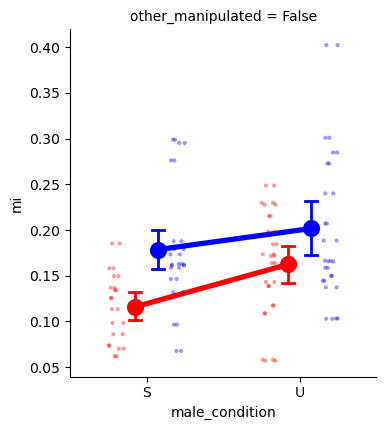

In [41]:
df_analysis = mi_df.reset_index()

df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]
df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == False]

df_analysis = df_analysis.groupby(["participant_nb", "male_condition", "female_condition", "other_manipulated"]).mean(numeric_only=True).reset_index()

g = sns.catplot(x="male_condition", y="mi", hue="female_condition"
            , units="participant_nb"
            , col="other_manipulated"
            , palette = ["#FF0000", "#0000FF"]
            , data=df_analysis, kind="point", sharey=False
            , aspect=0.9
            , capsize=.08
            , scale=1.4
            , dodge= 0.15
            , errwidth=2      
            , height=4.4
            , legend=False
           )

sns.stripplot(x="male_condition", y="mi"
              , hue="female_condition"
              , dodge=0.15, size=3, alpha=0.4, palette=["red", "blue"], legend=False
              , data=df_analysis
             )

#g.set(ylim=(-0.8, 0.9))

#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)

plt.savefig("plots/mi_other_manip.pdf", bbox_inches='tight')


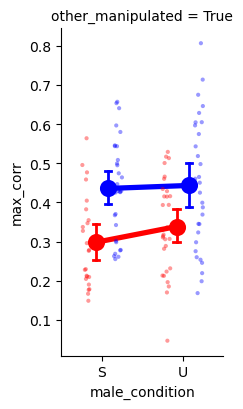

In [42]:
df_analysis = mi_df.reset_index()

df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]
df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == True]

df_analysis = df_analysis.groupby(["participant_nb", "male_condition", "female_condition", "other_manipulated"]).mean(numeric_only=True).reset_index()

g = sns.catplot(x="male_condition", y="max_corr", hue="female_condition"
            , units="participant_nb"
            , col="other_manipulated"
            , palette = ["#FF0000", "#0000FF"]
            , data=df_analysis, kind="point", sharey=False
            , aspect=0.6
            , capsize=.08
            , scale=1.4
            , dodge= 0.15
            , errwidth=2      
            , height=4.2     
            , legend=False
           )

sns.stripplot(x="male_condition", y="max_corr"
              , hue="female_condition"
              , dodge=0.15, size=3, alpha=0.4, palette=["red", "blue"], legend=False
              , data=df_analysis
             )

#g.set(ylim=(-0.8, 0.9))

#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)

plt.savefig("plots/max_corr_other_manip.pdf", bbox_inches='tight')


# Distributions

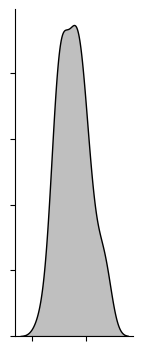

In [43]:
df_analysis = mi_df.groupby("dyad").mean(numeric_only=True)

g = sns.displot(df_analysis, x="max_corr", kind="kde", fill=True, aspect=0.5, height=4, color="black")
g.set(yticklabels=[], xticklabels=[], title='', xlabel=None, ylabel=None)
plt.savefig("plots/max_corr_dist.pdf",bbox_inches='tight')


In [45]:
from pingouin import ttest
df_analysis = mi_df.groupby("dyad").mean(numeric_only=True)
print(ttest(df_analysis["max_corr"].values, 0))

                T  dof alternative         p-val         CI95%   cohen-d  \
T-test  20.316018   56   two-sided  1.643154e-27  [0.35, 0.42]  2.690922   

             BF10  power  
T-test  1.959e+24    1.0  


# Unique Condition

In [46]:
def get_unique_condition(row):
    fc = row["female_condition"]
    mc = row["male_condition"]
    
    if fc < mc:
        return fc + mc
    else:
        return mc + fc
    

mi_df["unique_cond"] = mi_df.apply(get_unique_condition, axis=1)

PearsonRResult(statistic=0.8864788243219969, pvalue=4.7326648443453864e-20)


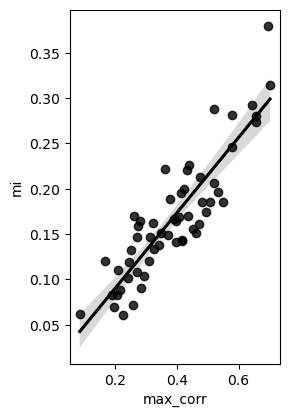

In [47]:
x = "max_corr"
y = "mi"

colors = ["#000000", "#000000"]
customPalette = sns.color_palette(colors)

g = sns.regplot(x=x, y=y, data=df_analysis, color="black")

g.figure.set_size_inches(2.7, 4.6)


a = df_analysis[x].values
b = df_analysis[y].values
print(stats.pearsonr(a, b))

#g.set(yticklabels=[], xticklabels=[], title='', xlabel=None, ylabel=None)
plt.savefig("plots/corr_mi_max_corr_legend.pdf", bbox_inches='tight')

# Lag analysis

In [49]:
df_lags = pd.read_csv("data/lags_df_py_feat_happiness_all_manipulated_pairs.csv")

In [50]:
def get_unique_condition(row):
    fc = row["female_condition"]
    mc = row["male_condition"]
    
    if fc < mc:
        return fc + mc
    else:
        return mc + fc
    

df_lags["unique_cond"] = df_lags.apply(get_unique_condition, axis=1)

KeyError: 'female_condition'

In [ ]:
df_analysis = df_lags
df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == True]
df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]

colors = ["#FF0000", "#0c0e0c", "#0000FF"]

g = sns.relplot(x="lag",y="corr", hue="unique_cond"
                , data=df_analysis, kind="line", aspect=0.8, height=4
                , legend=False
                , palette = colors
                , ci=68
                , linewidth = 2.3
               )

g.set(yticklabels=[], xticklabels=[], title='', xlabel=None, ylabel=None)

plt.savefig("plots/correlattion.pdf", bbox_inches='tight')